In [ ]:
import csv
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [155]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

In [156]:
NUM_CLASSES = 8

In [157]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [158]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [1]:
num_examples = X_dataset.shape[0]
print(f"Number of examples: {num_examples}")

NameError: name 'X_dataset' is not defined

In [159]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [160]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [161]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_18 (Dropout)        (None, 42)                0         
                                                                 
 dense_29 (Dense)            (None, 256)               11008     
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 8)                 520       
                                                                 
Total params: 52,680
Trainable params: 52,680
Non-trai

In [162]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [163]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [164]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
100/118 [========================>.....] - ETA: 0s - loss: 1.0071 - accuracy: 0.6408
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
118/118 [==============================] - 1s 3ms/step - loss: 0.9505 - accuracy: 0.6612 - val_loss: 0.2579 - val_accuracy: 0.9543
Epoch 2/1000
 95/118 [=======================>......] - ETA: 0s - loss: 0.5446 - accuracy: 0.8021
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
118/118 [==============================] - 0s 2ms/step - loss: 0.5361 - accuracy: 0.8060 - val_loss: 0.1869 - val_accuracy: 0.9597
Epoch 3/1000
 94/118 [======================>.......] - ETA: 0s - loss: 0.4414 - accuracy: 0.8436
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
118/118 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.8460 - val_loss: 0.1461 - val_accuracy: 0.9720
Epoch 4/1000
100/118 [========================>.....] - ETA: 0s - loss: 0.3467 - accu

In [165]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

40/40 [==============================] - 0s 867us/step - loss: 0.0310 - accuracy: 0.9948


In [166]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [167]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 35ms/step
[9.8827821e-01 3.8053276e-04 2.5281057e-04 8.3202478e-03 2.4623589e-03
 2.9419121e-04 2.7451749e-06 8.9231089e-06]
0


157/157 [==============================] - 0s 535us/step


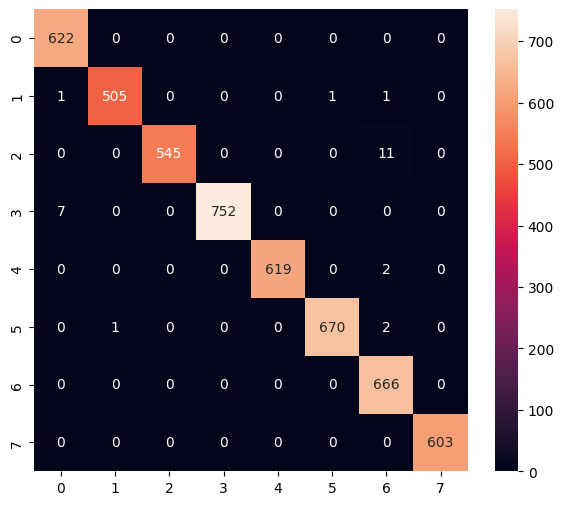

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       622
           1       1.00      0.99      1.00       508
           2       1.00      0.98      0.99       556
           3       1.00      0.99      1.00       759
           4       1.00      1.00      1.00       621
           5       1.00      1.00      1.00       673
           6       0.98      1.00      0.99       666
           7       1.00      1.00      1.00       603

    accuracy                           0.99      5008
   macro avg       1.00      0.99      0.99      5008
weighted avg       0.99      0.99      0.99      5008


In [168]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [169]:

# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [170]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ivadu\AppData\Local\Temp\tmp4umgiu42\assets


INFO:tensorflow:Assets written to: C:\Users\ivadu\AppData\Local\Temp\tmp4umgiu42\assets


58248